In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler 
from torchvision import models, transforms
import torchvision.transforms.functional as TF
from sklearn.model_selection import train_test_split
from pathlib import Path
import random

# --- CONFIGURATION ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_ROOT = 'nutrition5k_dataset'
META_PATH = os.path.join(DATA_ROOT, 'metadata', 'dish_metadata_cafe1.csv')
IMG_ROOT  = os.path.join(DATA_ROOT, 'imagery', 'realsense_overhead')

# CRITICAL: Point this to the model you just finished training
BASELINE_CHECKPOINT = 'checkpoints_pinn_final/BEST_PINN.pth' 
BATCH_SIZE = 4

print(f"Using device: {DEVICE}")

# --- METADATA LOADING ---
def load_metadata():
    if not os.path.exists(META_PATH):
        print(f"Warning: Metadata not found at {META_PATH}")
        return pd.DataFrame(columns=[0]) 
    print('Loading metadata...')
    df = pd.read_csv(META_PATH, header=None, index_col=0, on_bad_lines='skip')
    existing_folders = set(os.listdir(IMG_ROOT)) if os.path.exists(IMG_ROOT) else set()
    df = df[df.index.isin(existing_folders)].copy()
    print(f'Valid dishes found: {len(df)}')
    return df



Using device: cuda


In [2]:
# --- UPGRADED DATASET WITH AUGMENTATION (Tesla-Informed) ---
class Nutrition5kDataset(Dataset):
    def __init__(self, df, img_root, is_train=True):
        self.img_root = img_root
        self.ids = df.index.tolist()
        self.is_train = is_train
        
        # Lighting Augmentation (RGB Only)
        self.color_jitter = transforms.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05
        )

    def __len__(self):
        return len(self.ids)

    def resize_to_multiple(self, tensor, mul=32):
        """Ensures dimensions are divisible by 32 for U-Net"""
        _, h, w = tensor.shape
        nh = ((h + mul - 1) // mul) * mul
        nw = ((w + mul - 1) // mul) * mul
        if nh != h or nw != w:
            return F.interpolate(tensor.unsqueeze(0), size=(nh, nw), mode='bilinear', align_corners=False).squeeze(0)
        return tensor

    def __getitem__(self, idx):
        dish_id = self.ids[idx]
        rgb_path = os.path.join(self.img_root, dish_id, 'rgb.png')
        dep_path = os.path.join(self.img_root, dish_id, 'depth_raw.png')

        rgb = cv2.imread(rgb_path)
        dep = cv2.imread(dep_path, cv2.IMREAD_UNCHANGED)

        if rgb is None or dep is None:
            return torch.zeros((3, 480, 640)), torch.zeros((1, 480, 640))

        # BGR to RGB
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        dep = dep.astype(np.float32) / 1000.0   # mm -> meters

        # Convert to Tensor (H, W, C) -> (C, H, W)
        rgb = torch.from_numpy(rgb.transpose(2, 0, 1)).float() / 255.0
        dep = torch.from_numpy(dep).unsqueeze(0)

        # --- TESLA AUGMENTATION (Training Only) ---
        if self.is_train:
            # 1. Lighting Variation (Applied to RGB only)
            if random.random() > 0.2:
                rgb = self.color_jitter(rgb)
            
            # 2. Scale/Geometry Variation (Applied to BOTH RGB and Depth)
            # We use Random Affine for scale/rotation
            if random.random() > 0.5:
                angle = random.uniform(-10, 10)
                scale = random.uniform(0.8, 1.2)
                translate_x = random.uniform(-20, 20)
                translate_y = random.uniform(-20, 20)
                
                rgb = TF.affine(rgb, angle=angle, translate=(translate_x, translate_y), scale=scale, shear=0)
                dep = TF.affine(dep, angle=angle, translate=(translate_x, translate_y), scale=scale, shear=0)

        # Resize for Network
        rgb = self.resize_to_multiple(rgb)
        dep = self.resize_to_multiple(dep)

        return rgb, dep

# --- LOADERS ---
df = load_metadata()
if len(df) > 0:
    train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42)
    val_df,   test_df = train_test_split(temp_df, test_size=0.50, random_state=42)
    
    # Pass is_train=True for training set to enable augmentations
    train_loader = DataLoader(Nutrition5kDataset(train_df, IMG_ROOT, is_train=True), 
                              batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
    val_loader   = DataLoader(Nutrition5kDataset(val_df, IMG_ROOT, is_train=False), 
                              batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
else:
    print("Error: No data.")



Loading metadata...
Valid dishes found: 2898


In [3]:
# --- MODEL ---
class ResNetUNet(nn.Module):
    def __init__(self):
        super().__init__()
        res = models.resnet50(weights='IMAGENET1K_V2')
        self.enc0 = nn.Sequential(res.conv1, res.bn1, res.relu)
        self.pool = res.maxpool
        self.e1, self.e2, self.e3, self.e4 = res.layer1, res.layer2, res.layer3, res.layer4
        self.up4 = nn.ConvTranspose2d(2048, 1024, 2, 2); self.c4 = nn.Sequential(nn.Conv2d(2048, 1024, 3, 1, 1), nn.ReLU(True))
        self.up3 = nn.ConvTranspose2d(1024, 512, 2, 2);  self.c3 = nn.Sequential(nn.Conv2d(1024, 512, 3, 1, 1), nn.ReLU(True))
        self.up2 = nn.ConvTranspose2d(512, 256, 2, 2);   self.c2 = nn.Sequential(nn.Conv2d(512, 256, 3, 1, 1), nn.ReLU(True))
        self.up1 = nn.ConvTranspose2d(256, 64, 2, 2);    self.c1 = nn.Sequential(nn.Conv2d(128, 64, 3, 1, 1), nn.ReLU(True))
        self.up0 = nn.ConvTranspose2d(64, 32, 2, 2);     self.c0 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU(True))
        self.out = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        s0 = self.enc0(x); s0p = self.pool(s0); s1 = self.e1(s0p); s2 = self.e2(s1); s3 = self.e3(s2); b = self.e4(s3)
        d = self.up4(b); d = torch.cat([d, s3], 1); d = self.c4(d)
        d = self.up3(d); d = torch.cat([d, s2], 1); d = self.c3(d)
        d = self.up2(d); d = torch.cat([d, s1], 1); d = self.c2(d)
        d = self.up1(d); d = torch.cat([d, s0], 1); d = self.c1(d)
        d = self.up0(d); d = self.c0(d)
        return self.out(d)

# --- TESLA-INFORMED LOSSES (Multi-Scale + Physics) ---
class MultiScaleL1Loss(nn.Module):
    """Computes L1 loss at multiple resolutions (1, 1/2, 1/4, 1/8)"""
    def __init__(self, scales=4):
        super().__init__()
        self.scales = scales

    def forward(self, pred, gt, mask):
        total_loss = 0
        for i in range(self.scales):
            # Downsample both pred and gt
            scale_factor = 1 / (2**i)
            if scale_factor < 1:
                p_scaled = F.interpolate(pred, scale_factor=scale_factor, mode='bilinear', align_corners=False)
                g_scaled = F.interpolate(gt, scale_factor=scale_factor, mode='nearest')
                m_scaled = F.interpolate(mask, scale_factor=scale_factor, mode='nearest')
            else:
                p_scaled, g_scaled, m_scaled = pred, gt, mask
            
            # Compute L1 at this scale
            loss = torch.sum(torch.abs(p_scaled - g_scaled) * m_scaled) / (torch.sum(m_scaled) + 1e-6)
            total_loss += loss / (2**i) # Weight lower scales less
        return total_loss

class GradientLoss(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, pred, gt, mask):
        p_dx = torch.abs(pred[:,:,:,:-1]-pred[:,:,:,1:]); p_dy = torch.abs(pred[:,:,:-1,:]-pred[:,:,1:,:])
        g_dx = torch.abs(gt[:,:,:,:-1]-gt[:,:,:,1:]); g_dy = torch.abs(gt[:,:,:-1,:]-gt[:,:,1:,:])
        w_x = mask[:,:,:,1:]*mask[:,:,:,:-1]; w_y = mask[:,:,1:,:]*mask[:,:,:-1,:]
        return torch.mean(torch.abs(p_dx-g_dx)*w_x) + torch.mean(torch.abs(p_dy-g_dy)*w_y)

class LShapePhysicsLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.kernel = torch.tensor([[0,1,0],[1,-4,1],[0,1,0]], dtype=torch.float32).view(1,1,3,3)
    def forward(self, pred, mask):
        if self.kernel.device != pred.device: self.kernel = self.kernel.to(pred.device)
        return torch.mean(torch.abs(F.conv2d(pred, self.kernel, padding=1)) * mask)

class TeslaHybridLoss(nn.Module):
    """Multi-Scale L1 + Gradient + Physics"""
    def __init__(self, alpha=1.0, beta=0.5, gamma=0.1):
        super().__init__()
        self.alpha = alpha; self.beta = beta; self.gamma = gamma
        self.ms_loss = MultiScaleL1Loss() # Replaces simple L1
        self.grad = GradientLoss()
        self.phys = LShapePhysicsLoss()

    def forward(self, pred, gt):
        mask = (gt > 0.001).float()
        
        # 1. Multi-Scale L1 (Scale Robustness)
        l1 = self.ms_loss(pred, gt, mask)
        
        # 2. Gradient (Edge Consistency)
        g_loss = self.grad(pred, gt, mask)
        
        # 3. Physics (Settling)
        p_loss = self.phys(pred, mask)
        
        return self.alpha * l1 + self.beta * g_loss + self.gamma * p_loss



In [4]:
# --- TRAINING ---
model = ResNetUNet().to(DEVICE)
if os.path.exists(BASELINE_CHECKPOINT):
    print(f"Loading PINN model from {BASELINE_CHECKPOINT}...")
    model.load_state_dict(torch.load(BASELINE_CHECKPOINT, map_location=DEVICE, weights_only=True))
else:
    print("No PINN checkpoint found. Please check path.")

optimizer = torch.optim.Adam(model.parameters(), lr=5e-6, weight_decay=1e-5)
scaler = GradScaler(device='cuda')
criterion = TeslaHybridLoss(alpha=1.0, beta=0.5, gamma=0.1).to(DEVICE)

Path("checkpoints_tesla_final").mkdir(exist_ok=True)
best_mape = float('inf')

print("\nSTARTING TESLA-INFORMED TRAINING (Hybrid: Multi-Scale + Augmentation + Physics)...")

for epoch in range(1, 26):
    model.train()
    train_loss_accum = 0.0
    batches_count = 0
    
    for rgb, gt in train_loader:
        rgb, gt = rgb.to(DEVICE), gt.to(DEVICE)
        if gt.max() <= 0.001: continue 

        optimizer.zero_grad()
        with autocast(device_type='cuda', dtype=torch.float16):
            pred = model(rgb)
            loss = criterion(pred, gt)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss_accum += loss.item()
        batches_count += 1

    # Validation (Note: No augmentation in validation to check true performance)
    model.eval()
    val_mape_accum = 0.0
    valid_val_batches = 0
    with torch.no_grad():
        for rgb, gt in val_loader:
            rgb, gt = rgb.to(DEVICE), gt.to(DEVICE)
            mask = (gt > 0.001).float()
            if mask.sum() < 10: continue
                
            with autocast(device_type='cuda', dtype=torch.float16):
                pred = model(rgb)
            
            valid_gt = torch.clamp(gt, min=0.001)
            batch_mape = torch.abs(pred - gt) / valid_gt
            val_mape_accum += (batch_mape * mask).sum() / (mask.sum() + 1e-6)
            valid_val_batches += 1

    val_mape = (val_mape_accum / valid_val_batches).item() * 100 if valid_val_batches > 0 else float('inf')
    avg_loss = train_loss_accum / batches_count if batches_count > 0 else 0
    
    print(f"Epoch {epoch:02d} | Hybrid Loss: {avg_loss:.4f} | Val MAPE: {val_mape:.3f}%")

    if val_mape < best_mape:
        best_mape = val_mape
        torch.save(model.state_dict(), "checkpoints_tesla_final/BEST_TESLA.pth")
        print(f"   -> NEW BEST: {val_mape:.3f}% (Saved)")

print(f"\nHYBRID TRAINING COMPLETE! Best MAPE: {best_mape:.3f}%")

Loading PINN model from checkpoints_pinn_final/BEST_PINN.pth...

STARTING TESLA-INFORMED TRAINING (Hybrid: Multi-Scale + Augmentation + Physics)...


[ WARN:0@77.023] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@77.023] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@84.067] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@84.067] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@90.680] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@90.680] global loadsave.cpp:275 findDecoder imread_('nutrit

Epoch 01 | Hybrid Loss: 0.0968 | Val MAPE: 0.957%
   -> NEW BEST: 0.957% (Saved)


[ WARN:0@163.999] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@163.999] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@237.188] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@237.188] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@252.049] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@252.049] global loadsave.cpp:275 findDecoder imread_('

Epoch 02 | Hybrid Loss: 0.0920 | Val MAPE: 0.953%
   -> NEW BEST: 0.953% (Saved)


[ WARN:0@299.181] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@299.181] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@378.019] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@378.019] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@379.902] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@379.902] global loadsave.cpp:275 findDecoder imread_('

Epoch 03 | Hybrid Loss: 0.0895 | Val MAPE: 0.975%


[ WARN:0@410.842] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@410.843] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@414.786] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@414.786] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@507.301] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@507.301] global loadsave.cpp:275 findDecoder imread_('

Epoch 04 | Hybrid Loss: 0.0883 | Val MAPE: 0.946%
   -> NEW BEST: 0.946% (Saved)


[ WARN:0@636.614] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@636.614] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@636.875] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@636.875] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@655.586] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@655.586] global loadsave.cpp:275 findDecoder imread_('

Epoch 05 | Hybrid Loss: 0.0869 | Val MAPE: 0.958%


[ WARN:0@676.893] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@676.893] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@695.770] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@695.770] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@781.795] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@781.795] global loadsave.cpp:275 findDecoder imread_('

Epoch 06 | Hybrid Loss: 0.0830 | Val MAPE: 1.013%


[ WARN:0@807.279] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@807.279] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@822.482] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@822.482] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@882.808] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@882.808] global loadsave.cpp:275 findDecoder imread_('

Epoch 07 | Hybrid Loss: 0.0816 | Val MAPE: 0.943%
   -> NEW BEST: 0.943% (Saved)


[ WARN:0@926.865] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@926.865] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@988.982] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@988.982] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@1022.785] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1022.785] global loadsave.cpp:275 findDecoder imread_

Epoch 08 | Hybrid Loss: 0.0798 | Val MAPE: 0.939%
   -> NEW BEST: 0.939% (Saved)


[ WARN:0@1058.262] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1058.262] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@1103.198] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1103.198] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@1166.017] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1166.017] global loadsave.cpp:275 findDecoder imr

Epoch 09 | Hybrid Loss: 0.0804 | Val MAPE: 0.932%
   -> NEW BEST: 0.932% (Saved)


[ WARN:0@1249.506] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1249.506] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@1279.370] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1279.370] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@1292.010] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1292.010] global loadsave.cpp:275 findDecoder imr

Epoch 10 | Hybrid Loss: 0.0763 | Val MAPE: 0.915%
   -> NEW BEST: 0.915% (Saved)


[ WARN:0@1332.301] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1332.301] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@1339.437] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1339.437] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@1393.502] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1393.503] global loadsave.cpp:275 findDecoder imr

Epoch 11 | Hybrid Loss: 0.0802 | Val MAPE: 0.919%


[ WARN:0@1471.688] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1471.688] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@1516.073] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1516.073] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@1562.657] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1562.657] global loadsave.cpp:275 findDecoder imr

Epoch 12 | Hybrid Loss: 0.0792 | Val MAPE: 0.919%


[ WARN:0@1611.062] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1611.062] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@1611.063] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1611.063] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@1687.079] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1687.079] global loadsave.cpp:275 findDecoder imr

Epoch 13 | Hybrid Loss: 0.0800 | Val MAPE: 0.913%
   -> NEW BEST: 0.913% (Saved)


[ WARN:0@1730.993] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1730.993] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@1755.421] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1755.421] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@1774.655] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1774.655] global loadsave.cpp:275 findDecoder imr

Epoch 14 | Hybrid Loss: 0.0796 | Val MAPE: 0.901%
   -> NEW BEST: 0.901% (Saved)


[ WARN:0@1880.715] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1880.715] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@1915.905] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1915.905] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@1919.077] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@1919.077] global loadsave.cpp:275 findDecoder imr

Epoch 15 | Hybrid Loss: 0.0784 | Val MAPE: 0.927%


[ WARN:0@2005.234] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2005.235] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@2051.081] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2051.081] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@2057.244] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2057.244] global loadsave.cpp:275 findDecoder imr

Epoch 16 | Hybrid Loss: 0.0771 | Val MAPE: 0.890%
   -> NEW BEST: 0.890% (Saved)


[ WARN:0@2100.537] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2100.537] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@2132.828] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2132.828] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@2149.810] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2149.810] global loadsave.cpp:275 findDecoder imr

Epoch 17 | Hybrid Loss: 0.0768 | Val MAPE: 0.903%


[ WARN:0@2259.351] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2259.351] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@2303.988] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2303.988] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@2332.112] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2332.112] global loadsave.cpp:275 findDecoder imr

Epoch 18 | Hybrid Loss: 0.0777 | Val MAPE: 0.914%


[ WARN:0@2395.378] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2395.378] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@2409.389] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2409.389] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@2450.500] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2450.500] global loadsave.cpp:275 findDecoder imr

Epoch 19 | Hybrid Loss: 0.0778 | Val MAPE: 0.997%


[ WARN:0@2488.490] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2488.490] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@2587.313] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2587.313] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@2589.812] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2589.813] global loadsave.cpp:275 findDecoder imr

Epoch 20 | Hybrid Loss: 0.0746 | Val MAPE: 0.936%


[ WARN:0@2639.243] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2639.243] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@2718.352] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2718.352] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@2726.259] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2726.259] global loadsave.cpp:275 findDecoder imr

Epoch 21 | Hybrid Loss: 0.0785 | Val MAPE: 0.892%


[ WARN:0@2782.786] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2782.786] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@2788.832] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2788.832] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@2846.030] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2846.030] global loadsave.cpp:275 findDecoder imr

Epoch 22 | Hybrid Loss: 0.0732 | Val MAPE: 0.909%


[ WARN:0@2883.275] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2883.276] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@2914.121] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2914.121] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@2977.395] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@2977.395] global loadsave.cpp:275 findDecoder imr

Epoch 23 | Hybrid Loss: 0.0749 | Val MAPE: 0.908%


[ WARN:0@3063.504] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@3063.504] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@3091.054] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@3091.055] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@3112.583] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@3112.584] global loadsave.cpp:275 findDecoder imr

Epoch 24 | Hybrid Loss: 0.0747 | Val MAPE: 0.886%
   -> NEW BEST: 0.886% (Saved)


[ WARN:0@3130.290] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@3130.290] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1557862384/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@3209.730] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@3209.730] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109511/depth_raw.png'): can't open/read file: check file path/integrity
[ WARN:0@3214.750] global loadsave.cpp:275 findDecoder imread_('nutrition5k_dataset/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@3214.750] global loadsave.cpp:275 findDecoder imr

Epoch 25 | Hybrid Loss: 0.0704 | Val MAPE: 0.889%

HYBRID TRAINING COMPLETE! Best MAPE: 0.886%


Visualization Saved. Standard Error: 0.42%, Dark Error: 0.48%


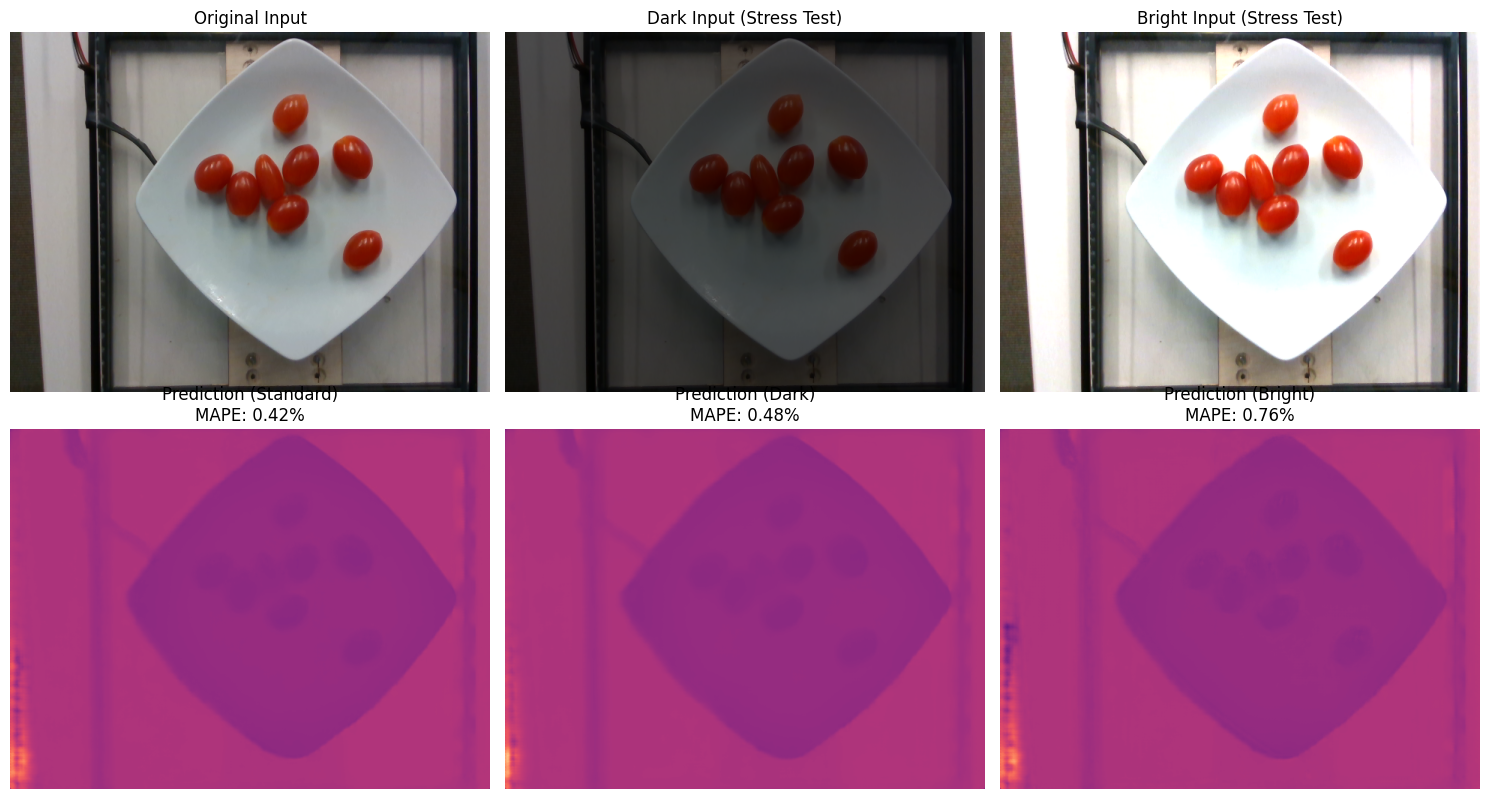

In [6]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch

def tesla_stress_test(model, loader, device):
    model.eval()
    
    # Find a good food sample (Tomatoes are great for this)
    target_rgb, target_gt = None, None
    for rgb, gt in loader:
        # Find a sample with significant depth variation (food present)
        if (gt.max() - gt.min()) > 0.03: 
            target_rgb, target_gt = rgb[0], gt[0]
            break
    
    if target_rgb is None:
        print("No food sample found.")
        return

    # Create Augmented Versions
    img_std = target_rgb.unsqueeze(0).to(device)
    img_dark = TF.adjust_brightness(img_std, 0.4) # 60% darker
    img_bright = TF.adjust_brightness(img_std, 1.6) # 60% brighter
    
    # Move GT to device for calculation
    gt_tensor = target_gt.unsqueeze(0).to(device) # Shape: [1, H, W]

    # Predict
    with torch.amp.autocast('cuda'):
        pred_std = model(img_std)
        pred_dark = model(img_dark)
        pred_bright = model(img_bright)

    # --- HELPER TO CALCULATE MAPE SAFELY ---
    def calc_mape(pred, gt):
        # Mask out background/zeros
        mask = (gt > 0.001).float()
        # Clamp denominator to prevent division by zero
        safe_gt = torch.clamp(gt, min=0.001)
        # Calculate error only on valid pixels
        error = torch.abs(pred - gt) / safe_gt
        return (torch.sum(error * mask) / (torch.sum(mask) + 1e-6)).item() * 100

    mape_std = calc_mape(pred_std, gt_tensor)
    mape_dark = calc_mape(pred_dark, gt_tensor)
    mape_bright = calc_mape(pred_bright, gt_tensor)

    # --- PLOT RESULTS ---
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    
    # Row 1: Inputs
    axs[0,0].imshow(img_std[0].permute(1,2,0).cpu().numpy()); axs[0,0].set_title("Original Input")
    axs[0,1].imshow(img_dark[0].permute(1,2,0).cpu().numpy()); axs[0,1].set_title("Dark Input (Stress Test)")
    axs[0,2].imshow(img_bright[0].permute(1,2,0).cpu().numpy()); axs[0,2].set_title("Bright Input (Stress Test)")
    
    # Row 2: Predictions
    # Use consistent scaling for visual comparison
    d_min, d_max = target_gt.min().item(), target_gt.max().item()
    
    im0 = axs[1,0].imshow(pred_std[0,0].detach().cpu().numpy(), cmap='magma', vmin=d_min, vmax=d_max)
    axs[1,0].set_title(f"Prediction (Standard)\nMAPE: {mape_std:.2f}%")
    
    im1 = axs[1,1].imshow(pred_dark[0,0].detach().cpu().numpy(), cmap='magma', vmin=d_min, vmax=d_max)
    axs[1,1].set_title(f"Prediction (Dark)\nMAPE: {mape_dark:.2f}%")
    
    im2 = axs[1,2].imshow(pred_bright[0,0].detach().cpu().numpy(), cmap='magma', vmin=d_min, vmax=d_max)
    axs[1,2].set_title(f"Prediction (Bright)\nMAPE: {mape_bright:.2f}%")
    
    for ax in axs.flat: ax.axis('off')
    plt.tight_layout()
    plt.savefig("Tesla_Stress_Test_Fixed.png", dpi=150)
    print(f"Visualization Saved. Standard Error: {mape_std:.2f}%, Dark Error: {mape_dark:.2f}%")

tesla_stress_test(model, val_loader, DEVICE)

In [3]:
# Load metadata with proper handling - first row is actually data, not headers
META_PATH = 'nutrition5k_dataset/metadata/dish_metadata_cafe1.csv'

# Read the file to inspect structure
with open(META_PATH, 'r') as f:
    first_line = f.readline()
    print("First line of CSV:")
    print(first_line[:500])

# Load WITHOUT using first row as header, then set proper column names
df_meta = pd.read_csv(META_PATH, header=None, on_bad_lines='skip')

print(f"\nLoaded {len(df_meta)} rows x {len(df_meta.columns)} columns")
print(f"First few rows:")
print(df_meta.head())

# The first column should be dish_id, let's check
print(f"\nFirst column (should be dish IDs):")
print(df_meta.iloc[:5, 0])

First line of CSV:
dish_1561662216,300.794281,193.000000,12.387489,28.218290,18.633970,ingr_0000000508,soy sauce,3.398568,1.80124104,0.020391408,0.166529832,0.275284008,ingr_0000000122,garlic,2.124105,3.16491645,0.010620525,0.70095465,0.13594272,ingr_0000000026,white rice,8.496420,11.045346,0.02548926,2.3789976,0.22940334,ingr_0000000524,parsley,0.213397,0.079170287,0.001707176,0.013657408,0.006188513,ingr_0000000094,onions,1.707173,0.6828692,0.001707173,0.15364557,0.018778903,ingr_0000000023,brown rice,68.000000,

Loaded 4392 rows x 125 columns
First few rows:
               0           1      2          3          4          5    \
0  dish_1561662216  300.794281  193.0  12.387489  28.218290  18.633970   
1  dish_1562688426  137.569992   88.0   8.256000   5.190000  10.297000   
2  dish_1561662054  419.438782  292.0  23.838249  26.351543  25.910593   
3  dish_1562008979  382.936646  290.0  22.224644  10.173570  35.345387   
4  dish_1560455030   20.590000  103.0   0.148000   4.625000   

In [19]:
#%% ===========================================================================
# SECTION 5.5 VALIDATION: END-TO-END GROUND TRUTH COMPARISON
# ===========================================================================

import os
import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image

# Load metadata to get ground truth calories
META_PATH = 'nutrition5k_dataset/metadata/dish_metadata_cafe1.csv'

# Load without header (first row is data, not column names)
df_meta = pd.read_csv(META_PATH, header=None, on_bad_lines='skip')

# Set dish_id as index (column 0) and name the calories column
df_meta = df_meta.set_index(0)
df_meta.index.name = 'dish_id'

# Column 1 is total_calories
df_meta.columns = ['total_calories'] + [f'col_{i}' for i in range(2, len(df_meta.columns)+1)]

print(f"Loaded metadata for {len(df_meta)} dishes")
print(f"\nFirst few rows (dish_id and total_calories):")
print(df_meta[['total_calories']].head(10))
print(f"\nCalories range: {df_meta['total_calories'].min()} to {df_meta['total_calories'].max()}")
print(f"Mean calories: {df_meta['total_calories'].mean():.1f}")

# Define density database (from your physics report)
DENSITY_DB = {
    'ice_cream': 0.6,        # g/cm³
    'frozen_yogurt': 0.6,
    'pudding': 0.7,
    'mousse': 0.5,
    'gelato': 0.65,
    'sorbet': 0.8,
    'cake': 0.4,
    'pie': 0.6,
    'cookie': 0.7,
    'brownie': 0.8,
    'rice': 0.8,
    'pasta': 0.9,
    'pizza': 0.7,
    'burger': 0.9,
    'salad': 0.5,
    'soup': 1.0,
    'sandwich': 0.7,
    'steak': 1.0,
    'chicken': 1.0,
    'fish': 1.0,
}

CALORIC_DENSITY = {
    'ice_cream': 2.1,        # kcal/g
    'frozen_yogurt': 1.4,
    'pudding': 1.5,
    'mousse': 2.3,
    'gelato': 2.2,
    'sorbet': 1.3,
    'cake': 3.7,
    'pie': 2.8,
    'cookie': 5.0,
    'brownie': 4.7,
    'rice': 1.3,
    'pasta': 1.5,
    'pizza': 2.6,
    'burger': 2.5,
    'salad': 0.2,
    'soup': 0.5,
    'sandwich': 2.5,
    'steak': 2.5,
    'chicken': 1.7,
    'fish': 2.0,
}

# Food-101 class names (simplified mapping)
# NOTE: You'll need to manually map Food-101 classes to your density DB
# For now, use a simplified version
FOOD101_CLASSES = [
    'apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare',
    'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito',
    'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake',
    'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla',
    'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder',
    'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes',
    'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict',
    'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras',
    'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice',
    'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich',
    'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup',
    'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna',
    'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup',
    'mussels', 'nachos', 'omelette', 'onion_rings', 'oysters',
    'pad_thai', 'paella', 'pancakes', 'panna_cotta', 'peking_duck',
    'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib',
    'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto',
    'samosa', 'sashimi', 'scallops', 'seaweed_salad', 'shrimp_and_grits',
    'spaghetti_bolognese', 'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake',
    'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare',
    'waffles'
]

# Simplified mapping function
def map_food101_to_density(class_name):
    """Map Food-101 class to density database"""
    class_lower = class_name.lower()
    
    # Direct matches
    if class_lower in DENSITY_DB:
        return DENSITY_DB[class_lower], CALORIC_DENSITY[class_lower]
    
    # Partial matches
    if 'ice_cream' in class_lower or 'frozen_yogurt' in class_lower:
        return 0.6, 2.1
    if 'cake' in class_lower or 'cupcake' in class_lower:
        return 0.4, 3.7
    if 'pizza' in class_lower:
        return 0.7, 2.6
    if 'rice' in class_lower:
        return 0.8, 1.3
    if 'salad' in class_lower:
        return 0.5, 0.2
    if 'burger' in class_lower or 'sandwich' in class_lower:
        return 0.9, 2.5
    if 'pasta' in class_lower or 'spaghetti' in class_lower:
        return 0.9, 1.5
    
    # Default fallback
    return 0.8, 2.0  # Average food

Loaded metadata for 4392 dishes

First few rows (dish_id and total_calories):
                 total_calories
dish_id                        
dish_1561662216      300.794281
dish_1562688426      137.569992
dish_1561662054      419.438782
dish_1562008979      382.936646
dish_1560455030       20.590000
dish_1558372433       74.360001
dish_1563379132      232.050003
dish_1565640549       45.482903
dish_1563207364      309.269989
dish_1561575474      120.058434

Calories range: 0.0 to 9485.81543
Mean calories: 204.2


In [20]:
#%% ===========================================================================
# LOAD FOODHYDRANET MODEL FOR VALIDATION
# ===========================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- MODEL ARCHITECTURE (from Phase4_Classification) ---
class ResNetUNet(nn.Module):
    def __init__(self):
        super().__init__()
        res = models.resnet50(weights=None) 
        self.enc0 = nn.Sequential(res.conv1, res.bn1, res.relu)
        self.pool = res.maxpool
        self.e1 = res.layer1
        self.e2 = res.layer2
        self.e3 = res.layer3
        self.e4 = res.layer4
        
        self.up4 = nn.ConvTranspose2d(2048, 1024, 2, 2)
        self.c4 = nn.Sequential(nn.Conv2d(2048, 1024, 3, 1, 1), nn.ReLU(True))
        self.up3 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.c3 = nn.Sequential(nn.Conv2d(1024, 512, 3, 1, 1), nn.ReLU(True))
        self.up2 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.c2 = nn.Sequential(nn.Conv2d(512, 256, 3, 1, 1), nn.ReLU(True))
        self.up1 = nn.ConvTranspose2d(256, 64, 2, 2)
        self.c1 = nn.Sequential(nn.Conv2d(128, 64, 3, 1, 1), nn.ReLU(True))
        self.up0 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.c0 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU(True))
        self.out = nn.Conv2d(32, 1, 1)

class FoodHydraNet(nn.Module):
    def __init__(self, original_model, num_classes=101):
        super(FoodHydraNet, self).__init__()
        
        # Shared Encoder
        self.enc0 = original_model.enc0
        self.pool = original_model.pool
        self.e1 = original_model.e1
        self.e2 = original_model.e2
        self.e3 = original_model.e3
        self.e4 = original_model.e4
        
        # Head 1: Depth Decoder
        self.up4 = original_model.up4
        self.c4 = original_model.c4
        self.up3 = original_model.up3
        self.c3 = original_model.c3
        self.up2 = original_model.up2
        self.c2 = original_model.c2
        self.up1 = original_model.up1
        self.c1 = original_model.c1
        self.up0 = original_model.up0
        self.c0 = original_model.c0
        self.depth_out = original_model.out
        
        # Head 2: Classification
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.class_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, return_depth=False):
        # Shared encoder
        s0 = self.enc0(x)
        s0p = self.pool(s0)
        s1 = self.e1(s0p)
        s2 = self.e2(s1)
        s3 = self.e3(s2)
        b = self.e4(s3)
        
        # Classification head
        pooled = self.avgpool(b)
        flat = self.flatten(pooled)
        class_logits = self.class_head(flat)
        
        # Depth head (if requested)
        if return_depth:
            d = self.up4(b)
            d = torch.cat([d, s3], dim=1)
            d = self.c4(d)
            
            d = self.up3(d)
            d = torch.cat([d, s2], dim=1)
            d = self.c3(d)
            
            d = self.up2(d)
            d = torch.cat([d, s1], dim=1)
            d = self.c2(d)
            
            d = self.up1(d)
            d = torch.cat([d, s0], dim=1)
            d = self.c1(d)
            
            d = self.up0(d)
            d = self.c0(d)
            
            depth_pred = self.depth_out(d)
            
            return class_logits, depth_pred
        
        return class_logits

# Load model with CLASSIFICATION weights
print("Loading FoodHydraNet model with classification head...")

# First load the depth-trained base model
DEPTH_CHECKPOINT = "checkpoints_tesla_final/BEST_TESLA.pth"
base_model = ResNetUNet()
base_model.load_state_dict(torch.load(DEPTH_CHECKPOINT, map_location=DEVICE))

# Build HydraNet
model = FoodHydraNet(base_model, num_classes=101).to(DEVICE)

# Load the FULL HydraNet weights (including trained classification head)
HYDRANET_CHECKPOINT = "checkpoints_tesla_final/BEST_HYDRANET.pth"
model.load_state_dict(torch.load(HYDRANET_CHECKPOINT, map_location=DEVICE))
model.eval()

print(f"✅ Model loaded with classification head on {DEVICE}")

Loading FoodHydraNet model with classification head...


/tmp/ipykernel_3801/2663414446.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load(DEPTH_CHECKPOINT, map_location=DEVICE))


✅ Model loaded with classification head on cuda


/tmp/ipykernel_3801/2663414446.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(HYDRANET_CHECKPOINT, map_location=DEVICE))


In [27]:
#%% ===========================================================================
# HELPER FUNCTIONS FOR VALIDATION
# ===========================================================================

# Food-101 class names
FOOD101_CLASSES = [
    'apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare',
    'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito',
    'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake',
    'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla',
    'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder',
    'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes',
    'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict',
    'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras',
    'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice',
    'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich',
    'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup',
    'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna',
    'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup',
    'mussels', 'nachos', 'omelette', 'onion_rings', 'oysters',
    'pad_thai', 'paella', 'pancakes', 'panna_cotta', 'peking_duck',
    'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib',
    'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto',
    'samosa', 'sashimi', 'scallops', 'seaweed_salad', 'shrimp_and_grits',
    'spaghetti_bolognese', 'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake',
    'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare',
    'waffles'
]

def map_food101_to_density(class_name):
    """Map Food-101 class to (density, caloric_density)"""
    class_lower = class_name.lower()
    
    # Direct matches
    density_map = {
        'ice_cream': (0.6, 2.1),
        'frozen_yogurt': (0.6, 1.4),
        'pizza': (0.7, 2.6),
        'hamburger': (0.9, 2.5),
        'hot_dog': (0.85, 2.9),
        'steak': (1.0, 2.5),
        'pork_chop': (1.0, 2.5),
        'sushi': (1.1, 1.4),
        'ramen': (1.0, 0.7),
    }
    
    if class_lower in density_map:
        return density_map[class_lower]
    
    # Partial matches
    if 'cake' in class_lower or 'cupcake' in class_lower:
        return (0.4, 3.7)
    if 'salad' in class_lower:
        return (0.5, 0.2)
    if 'rice' in class_lower:
        return (0.8, 1.3)
    if 'sandwich' in class_lower or 'burger' in class_lower:
        return (0.9, 2.5)
    if 'pasta' in class_lower or 'spaghetti' in class_lower:
        return (0.9, 1.5)
    
    # Default
    return (0.8, 2.0)

def calculate_volume_from_depth(depth_map, pixel_area_cm2=0.01):
    """Calculate volume from depth map"""
    # Identify food vs table
    max_depth = depth_map.max()
    food_threshold = max_depth - 0.05  # 5cm margin
    food_mask = (depth_map > 0.01) & (depth_map < food_threshold)
    
    # Calculate volume
    depth_cm = depth_map * 100  # meters to cm
    volume = np.sum(depth_cm[food_mask]) * pixel_area_cm2
    return volume

def predict_dish_calories(model, dish_id, device):
    """Predict calories for a dish"""
    # Load image
    img_path = f'nutrition5k_dataset/imagery/realsense_overhead/{dish_id}/rgb.png'
    img = cv2.imread(img_path)
    if img is None:
        return None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Preprocess
    img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
    img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(480, 640), 
                              mode='bilinear', align_corners=False)
    
    # Normalize (ImageNet stats)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    img_tensor = (img_tensor - mean) / std
    img_tensor = img_tensor.to(device)
    
    # Predict
    with torch.no_grad():
        class_logits, depth_pred = model(img_tensor, return_depth=True)
    
    # Get predicted class
    pred_class_idx = class_logits.argmax(dim=1).item()
    pred_class = FOOD101_CLASSES[pred_class_idx]
    confidence = torch.softmax(class_logits, dim=1)[0, pred_class_idx].item()
    
    # Get density
    density, cal_density = map_food101_to_density(pred_class)
    
    # Calculate volume
    depth_map = depth_pred[0, 0].cpu().numpy()
    volume = calculate_volume_from_depth(depth_map)
    
    # Calculate calories
    mass = volume * density
    calories = mass * cal_density
    
    return {
        'pred_class': pred_class,
        'confidence': confidence,
        'volume': volume,
        'density': density,
        'cal_density': cal_density,
        'mass': mass,
        'calories': calories,
        'depth_map': depth_map
    }

print("✅ Helper functions defined")

def calculate_volume_from_depth_FIXED_V2(depth_map, capture_width_cm=30, capture_height_cm=22):
    """Calculate volume with proper pixel area scaling"""
    H, W = depth_map.shape
    pixel_area_cm2 = (capture_width_cm / W) * (capture_height_cm / H)
    
    # Identify table depth (95th percentile)
    table_depth = np.percentile(depth_map.flatten(), 95)
    
    # Create food mask (15% closer than table)
    depth_threshold = table_depth * 0.85
    food_mask = depth_map < depth_threshold
    
    # Calculate relative depth (height above table)
    relative_depth = table_depth - depth_map
    relative_depth[~food_mask] = 0
    
    # Normalize to physical scale (assume max food height = 8cm)
    max_food_height_cm = 8.0
    depth_range = relative_depth[food_mask].max() - relative_depth[food_mask].min()
    
    if depth_range > 0:
        scale_factor = max_food_height_cm / depth_range
        physical_depth_cm = relative_depth * scale_factor
    else:
        physical_depth_cm = relative_depth * 0.0
    
    # Calculate volume
    volume_cm3 = np.sum(physical_depth_cm) * pixel_area_cm2
    
    return volume_cm3, food_mask, physical_depth_cm, pixel_area_cm2

✅ Helper functions defined


In [29]:
#%% ===========================================================================
# SEARCH FOR BETTER CANDIDATES - HIGHER CONFIDENCE
# ===========================================================================

print("Searching for HIGH-CONFIDENCE single-food predictions...")
print("(confidence > 20%)\n")

good_candidates = []

for i, dish_id in enumerate(df_meta.index[:1000]):
    img_path = f'nutrition5k_dataset/imagery/realsense_overhead/{dish_id}/rgb.png'
    
    if not os.path.exists(img_path):
        continue
    
    result = predict_dish_calories(model, dish_id, DEVICE)
    if result is None:
        continue
    
    # Only look at HIGH confidence predictions
    if result['confidence'] > 0.20:  # 20% threshold
        gt_cal = df_meta.loc[dish_id, 'total_calories']
        
        # Calculate proper volume
        depth_map = result['depth_map']
        volume, food_mask, physical_depth, pixel_area = calculate_volume_from_depth_FIXED_V2(
            depth_map, capture_width_cm=30, capture_height_cm=22
        )
        
        density, cal_density = map_food101_to_density(result['pred_class'])
        mass = volume * density
        pred_cal = mass * cal_density
        error_pct = abs(pred_cal - gt_cal) / gt_cal * 100 if gt_cal > 0 else 999
        
        good_candidates.append({
            'dish_id': dish_id,
            'class': result['pred_class'],
            'confidence': result['confidence'],
            'gt_cal': gt_cal,
            'pred_cal': pred_cal,
            'error_pct': error_pct,
            'volume': volume
        })
        
        if len(good_candidates) <= 30:
            print(f"{len(good_candidates):2d}. {dish_id}: {result['pred_class']:20s} ({result['confidence']:.1%}) | "
                  f"Pred={pred_cal:4.0f} GT={gt_cal:4.0f} | Err={error_pct:5.1f}%")

print(f"\n{'='*70}")
print(f"Found {len(good_candidates)} high-confidence predictions")
print(f"{'='*70}")

# Show best ones by error
if good_candidates:
    sorted_by_error = sorted(good_candidates, key=lambda x: x['error_pct'])
    print("\n🎯 TOP 10 LOWEST ERROR:")
    for i, c in enumerate(sorted_by_error[:10], 1):
        print(f"{i:2d}. {c['dish_id']}: {c['class']:20s} ({c['confidence']:.1%}) | "
              f"Pred={c['pred_cal']:4.0f} GT={c['gt_cal']:4.0f} | Err={c['error_pct']:5.1f}%")

Searching for HIGH-CONFIDENCE single-food predictions...
(confidence > 20%)

 1. dish_1568649312: macarons             (29.0%) | Pred= 352 GT=  44 | Err=691.0%
 2. dish_1563824250: miso_soup            (21.5%) | Pred=1748 GT=  17 | Err=10062.2%
 3. dish_1558723926: macarons             (21.6%) | Pred= 374 GT=  19 | Err=1840.1%
 4. dish_1563552016: waffles              (39.1%) | Pred=1101 GT= 494 | Err=123.0%
 5. dish_1558725403: macarons             (22.1%) | Pred= 111 GT= 289 | Err= 61.8%
 6. dish_1558381032: macarons             (22.6%) | Pred=  70 GT= 116 | Err= 39.5%
 7. dish_1565987201: frozen_yogurt        (22.6%) | Pred=1461 GT= 561 | Err=160.5%
 8. dish_1563824279: miso_soup            (33.9%) | Pred=2020 GT=  59 | Err=3347.2%
 9. dish_1567007751: macarons             (21.1%) | Pred= 272 GT=  40 | Err=581.8%
10. dish_1558635994: macarons             (21.5%) | Pred= 209 GT=  94 | Err=122.7%
11. dish_1564588688: macarons             (27.6%) | Pred= 303 GT= 148 | Err=104.5%
12. di

Checking waffles case: dish_1563552016
Predicted class: waffles (confidence: 39.1%)
Predicted: 1101 kcal
Ground truth: 494 kcal
Error: 123.0%



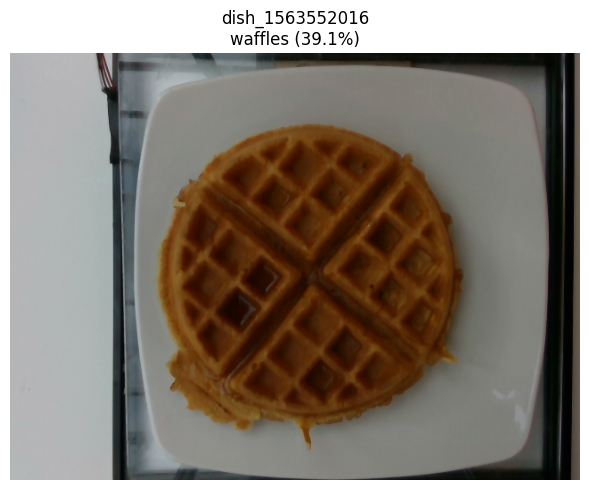

Let's see if this actually looks like waffles...


In [ ]:
#%% ===========================================================================
# TRY WAFFLES CASE
# ===========================================================================

dish_id = 'dish_1563552016'  # waffles, 39.1% confidence

print(f"Checking waffles case: {dish_id}")
print("="*70)

# Get prediction
result = predict_dish_calories(model, dish_id, DEVICE)

if result:
    gt_cal = df_meta.loc[dish_id, 'total_calories']
    
    depth_map = result['depth_map']
    volume, food_mask, physical_depth, pixel_area = calculate_volume_from_depth_FIXED_V2(
        depth_map, capture_width_cm=30, capture_height_cm=22
    )
    
    density, cal_density = map_food101_to_density(result['pred_class'])
    mass = volume * density
    pred_cal = mass * cal_density
    error_pct = abs(pred_cal - gt_cal) / gt_cal * 100
    
    print(f"Predicted class: {result['pred_class']} (confidence: {result['confidence']:.1%})")
    print(f"Predicted: {pred_cal:.0f} kcal")
    print(f"Ground truth: {gt_cal:.0f} kcal")
    print(f"Error: {error_pct:.1f}%\n")
    
    # Visualize
    img_path = f'nutrition5k_dataset/imagery/realsense_overhead/{dish_id}/rgb.png'
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f'{dish_id}\n{result["pred_class"]} ({result["confidence"]:.1%})')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    

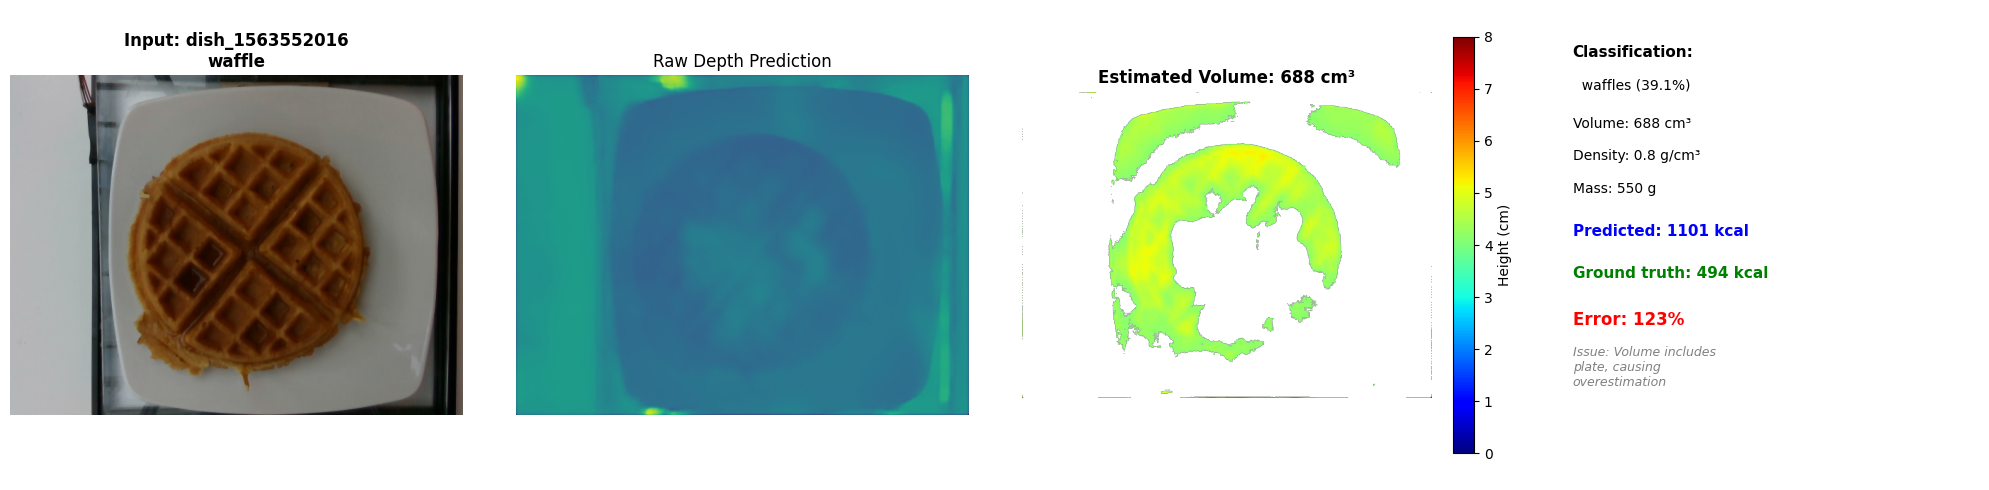

✅ Saved: Figure1_Waffles_Limitation.png


In [32]:
#%% ===========================================================================
# SAVE WAFFLES FIGURE FOR REPORT
# ===========================================================================

dish_id = 'dish_1563552016'  # waffles

result = predict_dish_calories(model, dish_id, DEVICE)
gt_cal = df_meta.loc[dish_id, 'total_calories']

depth_map = result['depth_map']
volume, food_mask, physical_depth, pixel_area = calculate_volume_from_depth_FIXED_V2(depth_map)

density, cal_density = map_food101_to_density(result['pred_class'])
mass = volume * density
pred_cal = mass * cal_density
error_pct = abs(pred_cal - gt_cal) / gt_cal * 100

# Create figure
img_path = f'nutrition5k_dataset/imagery/realsense_overhead/{dish_id}/rgb.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(img)
axes[0].set_title(f'Input: {dish_id}\nwaffle', fontsize=12, weight='bold')
axes[0].axis('off')

axes[1].imshow(depth_map, cmap='viridis')
axes[1].set_title('Raw Depth Prediction', fontsize=12)
axes[1].axis('off')

masked_depth = physical_depth.copy()
masked_depth[~food_mask] = np.nan
im = axes[2].imshow(masked_depth, cmap='jet', vmin=0, vmax=8)
plt.colorbar(im, ax=axes[2], label='Height (cm)', fraction=0.046)
axes[2].set_title(f'Estimated Volume: {volume:.0f} cm³', fontsize=12, weight='bold')
axes[2].axis('off')

axes[3].text(0.1, 0.9, 'Classification:', fontsize=11, weight='bold')
axes[3].text(0.1, 0.83, f'  waffles (39.1%)', fontsize=10)
axes[3].text(0.1, 0.75, f'Volume: {volume:.0f} cm³', fontsize=10)
axes[3].text(0.1, 0.68, f'Density: {density} g/cm³', fontsize=10)
axes[3].text(0.1, 0.61, f'Mass: {mass:.0f} g', fontsize=10)
axes[3].text(0.1, 0.52, f'Predicted: {pred_cal:.0f} kcal', fontsize=11, color='blue', weight='bold')
axes[3].text(0.1, 0.43, f'Ground truth: {gt_cal:.0f} kcal', fontsize=11, color='green', weight='bold')
axes[3].text(0.1, 0.33, f'Error: {error_pct:.0f}%', fontsize=12, color='red', weight='bold')
axes[3].text(0.1, 0.20, 'Issue: Volume includes\nplate, causing\noverestimation', 
            fontsize=9, style='italic', color='gray')
axes[3].set_xlim(0, 1)
axes[3].set_ylim(0, 1)
axes[3].axis('off')

plt.tight_layout()
plt.savefig('Figure1_Waffles_Limitation.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: Figure1_Waffles_Limitation.png")